# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Установка и импорт необходимых библиотек

In [15]:
!pip install lightgbm

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
from time import time

warnings.filterwarnings('ignore')
%matplotlib inline

## Подготовка данных

In [17]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv(r'C:\Users\pulka\OneDrive\Рабочий стол\численные методы\проект численнын методы/autos.csv')

In [18]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Количество пропусков в данных.

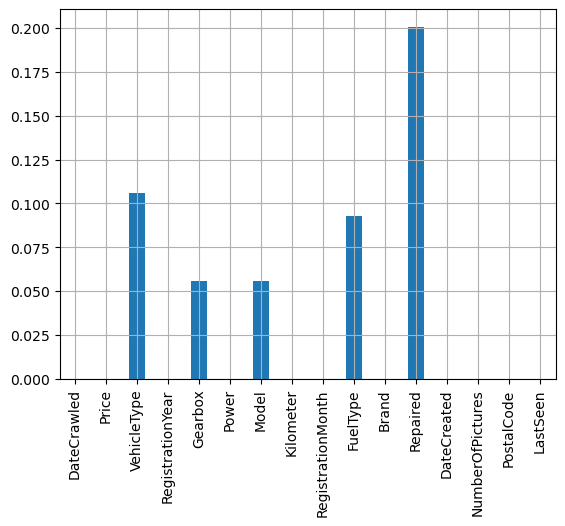

In [20]:
df.isna().mean().plot(kind = 'bar', grid = True);

Удалим строки с пропущенными значениями , там где их меньше 10 процентов : `Gearbox`, `Model`, `FuelType`

In [21]:
df = df.dropna(subset= ['Gearbox', 'Model', 'FuelType'])

Удалим явные дубликаты. 

In [22]:
df = df.drop_duplicates()

In [23]:
#Посмотрим сколько данных удалили.
print(((354369 - len(df))/354369)*100,'%')

15.561462769034536 %


In [24]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

#### Рассмотрим каждый столбец отдельно.

- цена

<AxesSubplot: >

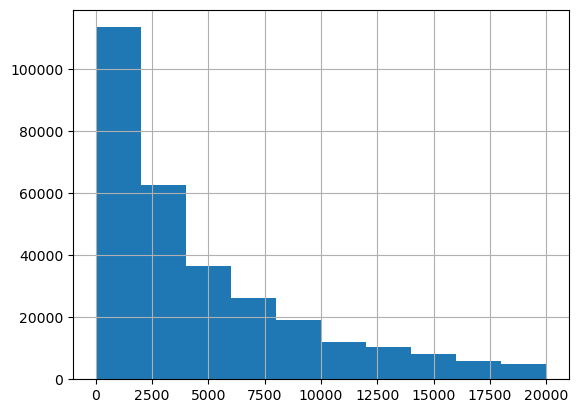

In [25]:
df.Price.hist()

In [26]:
df = df.query('Price >1')

- тип автомобильного кузова

In [27]:
df.VehicleType.unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

In [28]:
df.VehicleType.value_counts(dropna = False)

sedan          81374
small          68673
wagon          57792
bus            26033
convertible    17952
NaN            14121
coupe          13895
suv            10530
other           2343
Name: VehicleType, dtype: int64

In [29]:
df.groupby(['Model', 'VehicleType'])['VehicleType'].count()

Model   VehicleType
100     convertible      1
        coupe            2
        sedan          250
        wagon           93
145     coupe            2
                      ... 
zafira  other           19
        sedan           19
        small            9
        suv              5
        wagon          171
Name: VehicleType, Length: 1083, dtype: int64

Так как невозможно однозначно определить тип кузова, отнесем все к категории `other`. <br>
Можно было бы заполнить тип кузова в зависимости от модели, но у одной модели может быть несколько вариантов кузова.

In [30]:
df['VehicleType'] = df['VehicleType'].fillna('other')

- год регистрации автомобиля

In [31]:
df.RegistrationYear.value_counts()

1999    19102
2005    18387
2006    18148
2000    17967
2003    17695
        ...  
1936        1
1935        1
1934        1
1400        1
1600        1
Name: RegistrationYear, Length: 95, dtype: int64

In [32]:
df.RegistrationYear.unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 2005, 2011, 2007, 2009, 2002,
       2018, 1997, 1990, 1981, 2003, 2016, 1984, 2006, 1999, 1998, 2017,
       2012, 2010, 2000, 1992, 2013, 1994, 1991, 1996, 1989, 2015, 1985,
       1982, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965, 1970,
       1945, 1974, 1955, 1978, 1976, 1979, 1972, 1977, 1966, 1975, 1963,
       1961, 1967, 1960, 1964, 1910, 1968, 1937, 1951, 1953, 2019, 1954,
       1959, 1958, 1956, 2900, 1962, 1400, 1950, 1932, 1952, 3700, 5000,
       1942, 1957, 1923, 1930, 1943, 1938, 1934, 1935, 1936, 1000, 1929,
       6000, 1928, 1931, 1927, 1933, 1947, 1600], dtype=int64)

<AxesSubplot: >

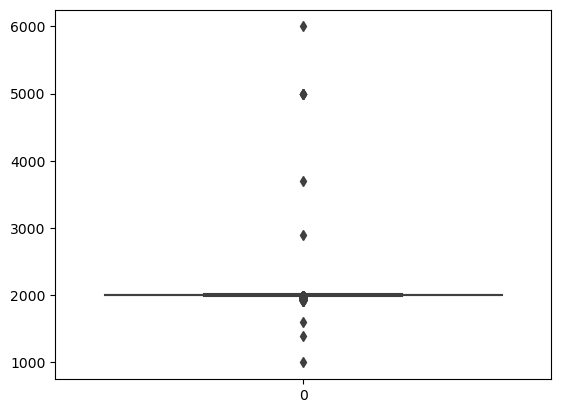

In [33]:
sns.boxplot(df.RegistrationYear)

In [34]:
q1 = df['RegistrationYear'].quantile(0.25)
q3 = df['RegistrationYear'].quantile(0.75)
qmin = q1 - 1.5*(q3-q1)
qmax = q3 + 1.5*(q3 - q1)
print(f'q1 = {q1}')
print(f'q3 = {q3}')
print(f'qmin = {qmin}')
print(f'qmax = {qmax}')

q1 = 1999.0
q3 = 2007.0
qmin = 1987.0
qmax = 2019.0


In [35]:
df = df.loc[df['RegistrationYear'].between(1900, 2016)]

Значения вроде 1000, 6000 и т.д. явно записаны ошибочно, их никак не обработать( поделить на что-то и т.д.). Ограничим временной период с 1900 по 2016 годы. Максимально возможный год регистрации должен соответствовать дате скачивания анкеты (DateCrawled) в 2016 году.

- Тип коробки передач

In [36]:
df.Gearbox.unique()

array(['manual', 'auto'], dtype=object)

- мощность (л. с.)

In [37]:
df.Power.unique()

array([    0,   163,    75,    69,   102,   109,   125,   105,   140,
         115,   190,   136,   160,   231,    50,   118,   193,    99,
          60,   113,   218,   122,   129,    70,    95,    61,   177,
         170,   143,   101,   232,   156,    80,    82,    90,   155,
         150,   185,    87,   180,    86,   131,   224,   235,   200,
         178,   265,    77,   110,   120,    54,   286,   116,   184,
         204,    88,   194,    64,   305,   197,   179,   250,   313,
          45,    98,    41,   130,   114,   211,    56,   201,   213,
         107,   174,   100,   220,    73,   192,    66,    74,    58,
          52,   147,    71,    97,    65,   239,    68,   203,   144,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
          83,   145,    55,   280,   260,   104,   306,   188,   333,
         117,   141,   132,   165,   234,   158,    39,    92,    51,
         135,    59,   230,    53,    84,   209,    43,   146,    67,
         106,   276,

<AxesSubplot: >

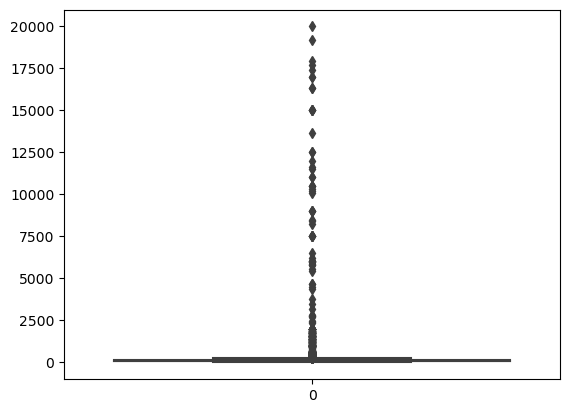

In [38]:
sns.boxplot(df.Power)

In [39]:
df['Power'].min()

0

Если проанализировать модели авто, то можно заметить, что все авто условно среднего класс, спорткаров нет. Мощности больше 200-300 л.с. у них не могут быть. Обработаем данные.

In [40]:
df.loc[df['Power'] > 999,'Power'] = df['Power']/10
df.loc[df['Power'] > 9999,'Power'] = df['Power']/100

- модель автомобиля

In [41]:
df.Model.unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'twingo', 'a_klasse', 'scirocco', '5er',
       'arosa', 'other', 'civic', 'transporter', 'punto', 'e_klasse',
       'clio', 'one', 'fortwo', '1er', 'b_klasse', 'astra', 'a8', 'jetta',
       'polo', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'slk', '7er', 'corsa', '80', '147',
       'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'insignia', 'ka', 'almera', 'megane', 'a3', 'lupo', 'r19',
       'caddy', 'mondeo', 'colt', 'vectra', 'berlingo', 'tiguan',
       'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed',
       'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'rio',
       'touareg', 'logan', 'omega', 'cuore', 's_max', 'a2', 'galaxy',
       'c3', 'vi

In [42]:
df.groupby('Model')['Price'].agg(['mean', 'max']).sort_values(by = 'mean', ascending = False)

,mean,max
Model,,
gl,18378.833333,20000
glk,16580.196721,20000
a5,15903.287091,20000
q5,15843.989691,20000
q7,15658.699482,19999
...,...,...
seicento,852.179732,7950
move,723.923077,2500
samara,624.500000,2199


- пробег (км)

In [43]:
df.Kilometer.unique()

array([150000, 125000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000], dtype=int64)

<AxesSubplot: xlabel='Kilometer', ylabel='Price'>

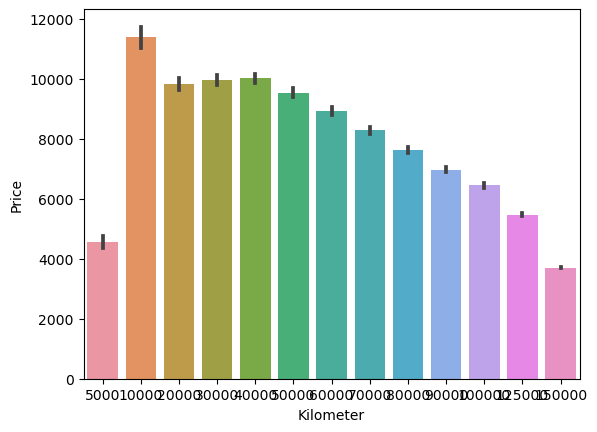

In [44]:
sns.barplot( x = df.Kilometer, y = df.Price)

- месяц регистрации автомобиля

In [45]:
df.RegistrationMonth.unique()

array([ 0,  8,  6,  7, 10, 12, 11,  3,  2,  1,  4,  5,  9], dtype=int64)

- тип топлива

In [46]:
df.FuelType.unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

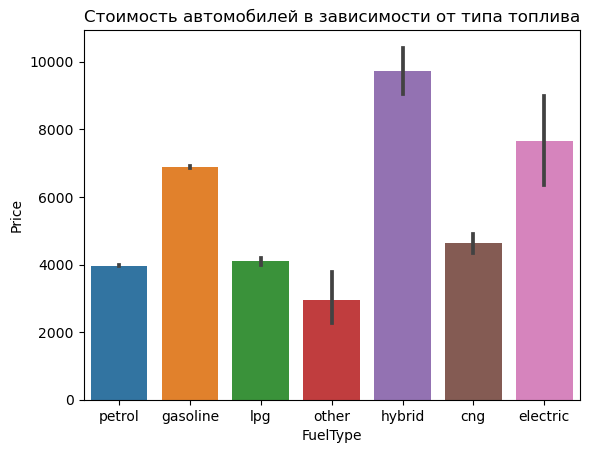

In [47]:
plt.title('Стоимость автомобилей в зависимости от типа топлива')
sns.barplot(x = df['FuelType'], y = df['Price']);

- марка автомобиля

In [48]:
df.Brand.unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'mini', 'smart', 'opel', 'audi', 'alfa_romeo', 'subaru', 'volvo',
       'mitsubishi', 'kia', 'hyundai', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [49]:
df.groupby('Brand')['Price'].agg(['mean', 'max']).sort_values(by = 'mean', ascending = False)

,mean,max
Brand,,
porsche,12372.489396,20000
mini,9307.940144,20000
land_rover,8901.351967,20000
jeep,7597.235915,20000
jaguar,7118.101580,20000
audi,6837.671001,20000
bmw,6700.354784,20000
mercedes_benz,6316.136739,20000
skoda,6210.348676,20000


 - была машина в ремонте или нет

In [50]:
df['Repaired'].value_counts(dropna=False)

no     218270
NaN     40185
yes     27504
Name: Repaired, dtype: int64

In [51]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [52]:
df.query('Repaired == "unknown"').head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0.0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Так как по другим характеристикам невозможно однозначно сказать был ли автомобиль в ремонте или нет, заполним пропуски фразой `unknown`.

-  дата создания анкеты

In [53]:
df.DateCreated

0         2016-03-24 00:00:00
2         2016-03-14 00:00:00
3         2016-03-17 00:00:00
4         2016-03-31 00:00:00
5         2016-04-04 00:00:00
                 ...         
354362    2016-03-19 00:00:00
354363    2016-03-27 00:00:00
354366    2016-03-05 00:00:00
354367    2016-03-19 00:00:00
354368    2016-03-20 00:00:00
Name: DateCreated, Length: 285959, dtype: object

- количество фотографий автомобиля

In [54]:
df.NumberOfPictures.unique()

array([0], dtype=int64)

-  почтовый индекс владельца анкеты (пользователя)

In [55]:
df.PostalCode.unique()

array([70435, 90480, 91074, ..., 67159, 89344, 24363], dtype=int64)

- дата последней активности пользователя

In [56]:
df.LastSeen.unique()

array(['2016-04-07 03:16:57', '2016-04-05 12:47:46',
       '2016-03-17 17:40:17', ..., '2016-04-02 18:16:20',
       '2016-03-19 20:44:43', '2016-03-29 10:17:23'], dtype=object)

In [57]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [58]:
corr = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired']].corr()

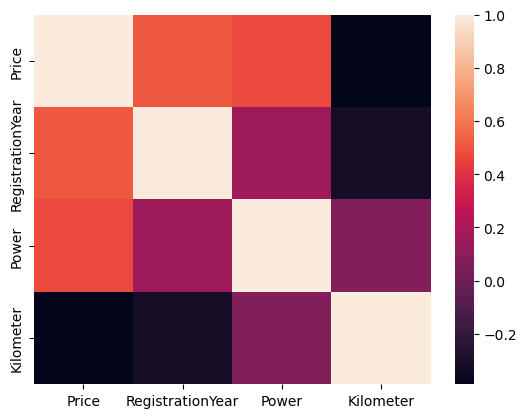

In [59]:
sns.heatmap(corr);

## Обучение моделей

### Подготовка данных.

Определяем признаки для прогноза и целевой признак.

In [60]:
X = df[['VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired']]
y =df['Price']

Выделяем тренировочную, тестовую выборки.

In [61]:
# тренировочная и тестовая выбрки 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [62]:
print(f'Размерность всей выборки{X.shape}')

Размерность всей выборки(285959, 9)


In [63]:
print(f'Размерность тренировочной выборки{X_train.shape}')

Размерность тренировочной выборки(200171, 9)


In [64]:
print(f'Размерность тестовой выборки{X_test.shape}')

Размерность тестовой выборки(85788, 9)


In [65]:
# проверка размерности выборок
X_train.shape[0] + X_test.shape[0] - X.shape[0]

0

In [66]:
# масщтабирование числовых данных
numeric_preproces = Pipeline([('scaler',StandardScaler())])

In [67]:
# кодирование категориальных данных 
categorial_preproces = Pipeline([('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

In [68]:
# процесс подготовки данных для Случайного леса
preprocessor_for_tree = ColumnTransformer([
    (
        'categorical', 
        categorial_preproces, 
        X.select_dtypes(include=['object']).columns
    ),
    (
        'numerical', 
        numeric_preproces, 
        X.select_dtypes(include=['number']).columns
    )
])

In [69]:
# Процесс подготовки данных для бустингов
preprocessor_for_boost = ColumnTransformer([
    (
        'numerical', 
        numeric_preproces, 
        X.select_dtypes(include=['number']).columns
    )
])

In [70]:

pipe_for_tree = Pipeline([
    ('preprocessor', preprocessor_for_tree),
    ('classifier', RandomForestRegressor(random_state=42))
])

In [71]:

pipe_for_lgbm = Pipeline([
    ('preprocessor', preprocessor_for_tree),
    ('classifier', LGBMRegressor(random_state=42))
])

In [72]:

pipe_for_catboost = Pipeline([
    ('preprocessor', preprocessor_for_tree),
    ('classifier', CatBoostRegressor(random_state=42))
])

### Random Forest

In [73]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}

In [74]:
grid_tree =  GridSearchCV(pipe_for_tree, param, cv = 5, scoring= 'neg_mean_squared_error')

In [75]:
start_time = time()
grid_tree.fit(X_train,y_train)
run_time_1 = time() - start_time

In [76]:
start_time = time()
predict_rf = grid_tree.predict(X_train)
run_time_1_1 = time() - start_time

In [77]:
scores_1 = grid_tree.best_score_

In [78]:
RMSE_forest = np.abs(scores_1.mean())**0.5
print(RMSE_forest)

1863.3176753192845


### Light GBM

In [79]:
param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10]
}

In [80]:
grid_lgbm = GridSearchCV(pipe_for_lgbm, param, cv = 5, scoring= 'neg_mean_squared_error')

In [81]:
start_time = time()
grid_lgbm.fit(X_train, y_train)
run_time_2 = time() - start_time

In [82]:
start_time = time()
predict = grid_lgbm.predict(X_train)
run_time_2_1 = time() - start_time

In [83]:
scores_2 = grid_lgbm.best_score_

In [84]:
RMSE_lgbm = np.abs(scores_2)**0.5
print(RMSE_lgbm)

1609.9908551555948


### CatBoost

In [85]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

In [87]:
scaler = StandardScaler()
scaler.fit_transform(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [88]:
cat_features = ['VehicleType', 'Gearbox','Model', 'FuelType', 'Brand', 'Repaired']

In [89]:
model = CatBoostRegressor(random_state=42)

In [95]:
start_time = time()
model.fit (X_train, y_train, cat_features = cat_features, verbose = False)
run_time_3 = time() - start_time

In [96]:
start_time = time()
predict = model.predict(X_train)
run_time_3_1 = time() - start_time

In [97]:
RMSE_catboost = np.abs(mean_squared_error(y_train,predict ).mean())**0.5
print(RMSE_catboost)

1497.6199915503385


## Анализ моделей

In [99]:
columns  = ['Время обучения', 'Время прогноза', 'Метрика RMSE']
index = ['Random Forest', 'Light GBM', 'Cat Boost']

In [100]:
pd.DataFrame(data = [[run_time_1,run_time_1_1,RMSE_forest],
            [run_time_2,run_time_2_1,RMSE_lgbm],
            [run_time_3,run_time_3_1,RMSE_catboost]],index = index, columns = columns )

,Время обучения,Время прогноза,Метрика RMSE
Random Forest,675.823628,3.978400,1863.317675
Light GBM,22.465712,0.766270,1609.990855
Cat Boost,104.232616,0.800743,1497.619992


## Тестирование лучшей модели

Проверим метрику лучшей модели на тестовой выборке.

In [101]:
pred_tesr = model.predict(X_test)

In [102]:
RMSE = np.abs(mean_squared_error(y_test, pred_tesr))**0.5

In [103]:
print(RMSE)

1570.5649175624253


## Вывод:

На основе полученных данных о продаже автомобилей мы обучили три модели по определению цены автомобилей : Random Forest, Light GBM, Cat Boost.
Критериями для выбора модели было:
    - качество предсказания;
    - время обучения модели;
    - время предсказания модели.
По итогу получили следующее.<br>
Самое быстрое `время` как обучения, так и прогноза имеет модель `Light GBM`.<br>
Лучшая `метрика` у модели `Сat Boost`.<br>
Модель Random Forest имеет схожую с моделью Сat Boost метрику, но времени для обучения требует в разы больше.<br>
Для выбора наиболее подходящей между `Light GBM` и `Cat Boost` нужно узнать что ценее-скорость или качество.<br>
На данном этапе выберем Catboost.

Метрика RMSE Catboost на тестовой выборке- 1570.